# TCC Bruno Cunha Zago - Ciência de Dados e Big Data - PUC Minas

## USO DE MACHINE LEARNING PARA PREVER ACIDENTES EM RODOVIAS BRASILEIRAS COM FOCO EM CONTRATOS DE MANUTENÇÃO

# 1 - Importando bibliotecas

In [1]:
#Carregamento de bibliotecas gerais
import requests
import zipfile
import io
import pandas as pd
import xlrd
import calendar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from dateutil import rrule, parser
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor

# Desativar FutureWarnings
warnings.filterwarnings('ignore')

# 1 - Definição do Problema

O objetivo é utilizar dados do DATATRAN e do SNV para prever o número de acidentes em rodovias federais causados por problemas na via e identificar padrões de ocorrência de acidentes em rodovias brasileiras.

Em seguida, pretende-se estudar modelos de machine learning para estimar o número de acidentes por meio dos dados de contratos de manutenção rodoviária. Para isso, cada segmento do SNV será avaliado para determinar o número de acidentes em cada um deles.

O objetivo final é criar uma ferramenta que estima o número de acidentes com base nos dados de contratos de manutenção. Isso permitirá identificar quais segmentos apresentam maior número de acidentes e, assim, propor ações preventivas em locais específicos, auxiliando o DNIT e as empresas contratadas na tomada de decisão quanto à alocação de recursos e ações preventivas em trechos de rodovias que apresentam maior risco de acidentes.

# 2 - Coleta de Dados

# 2.1 - Base de Acidentes (tabela datatran)

In [2]:
# Baixando e extraindo o arquivo
extract_path = r"C:\Users\bcz87" #caminho de extração
urls = [
    "https://drive.google.com/u/0/uc?id=1PRQjuV5gOn_nn6UNvaJyVURDIfbSAK4-&export=download",
    "https://drive.google.com/u/0/uc?id=12xH8LX9aN2gObR766YN3cMcuycwyCJDz&export=download",
    "https://drive.google.com/u/0/uc?id=1esu6IiH5TVTxFoedv6DBGDd01Gvi8785&export=download",
    "https://drive.google.com/u/0/uc?id=1pN3fn2wY34GH6cY-gKfbxRJJBFE0lb_l&export=download",
    "https://drive.google.com/u/0/uc?id=1cM4IgGMIiR-u4gBIH5IEe3DcvBvUzedi&export=download",
    "https://drive.google.com/u/0/uc?id=1HPLWt5f_l4RIX3tKjI4tUXyZOev52W0N&export=download",
    "https://drive.google.com/u/0/uc?id=16qooQl_ySoW61CrtsBbreBVNPYlEkoYm&export=download",
    "https://drive.google.com/u/0/uc?id=1DyqR5FFcwGsamSag-fGm13feQt0Y-3Da&export=download",
    "https://drive.google.com/u/0/uc?id=1FpF5wTBsRDkEhLm3z2g8XDiXr9SO9Uk8&export=download",
    "https://drive.google.com/u/0/uc?id=1p_7lw9RzkINfscYAZSmc-Z9Ci4ZPJyEr&export=download",
    "https://drive.google.com/u/0/uc?id=18Yz2prqKSLthrMmW-73vrOiDmKTCL6xE&export=download",
    "https://drive.google.com/u/0/uc?id=1HHhgLF-kSR6Gde2qOaTXL3T5ieD33hpG&export=download",
    "https://drive.google.com/u/0/uc?id=1_yU6FRh8M7USjiChQwyF20NtY48GTmEX&export=download",
    "https://drive.google.com/u/0/uc?id=1qkVatg0pC_zosuBs0NCSgEXDJvBbnTYC&export=download",
    "https://drive.google.com/u/0/uc?id=1_OSeHlyKJw8cIhMS_JzSg1RlYX8k6vSG&export=download",
    "https://drive.google.com/u/0/uc?id=1EFpZF5F6cB0DOHd2Uxnj7X948WE69a8e&export=download"
]
file_names = [
    "datatran2022.zip",
    "datatran2021.zip",
    "datatran2020.zip",
    "datatran2019.zip",
    "datatran2018.zip",
    "datatran2017.zip",
    "datatran2016.zip",
    "datatran2015.zip",
    "datatran2014.zip",
    "datatran2013.zip",
    "datatran2012.zip",
    "datatran2011.zip",
    "datatran2010.zip",
    "datatran2009.zip",
    "datatran2008.zip",
    "datatran2007.zip"
]

for url, file_name in zip(urls, file_names):
    response = requests.get(url)
    open(file_name, "wb").write(response.content)
    
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [3]:
# Carregando arquivo
# Lista com o nome dos arquivos
file_names = ['datatran2022.csv', 'datatran2021.csv', 'datatran2020.csv', 'datatran2019.csv',
              'datatran2018.csv', 'datatran2017.csv', 'datatran2016.csv', 'datatran2015.csv',
              'datatran2014.csv', 'datatran2013.csv', 'datatran2012.csv', 'datatran2011.csv',
              'datatran2010.csv', 'datatran2009.csv', 'datatran2008.csv', 'datatran2007.csv']

# Caminho dos arquivos
path = r"C:\\Users\\bcz87\\"

# Lista para armazenar os dataframes
dfs = []

# Loop para ler cada arquivo e armazená-lo na lista dfs
for file in file_names:
    df = pd.read_csv(path + file, sep=';', decimal=',', encoding = 'cp1252', low_memory=False)
    dfs.append(df)

# Concatenação dos dataframes na mesma tabela
datatran = pd.concat(dfs, ignore_index=True)

# Exibir as primeiras linhas da tabela
print(datatran.head())

         id data_inversa dia_semana   horario  uf     br     km  \
0  405151.0   2022-01-01     sábado  01:35:00  PI  316.0  415.0   
1  405158.0   2022-01-01     sábado  02:40:00  PR  116.0   33.0   
2  405172.0   2022-01-01     sábado  05:22:00  MS  163.0  393.0   
3  405203.0   2022-01-01     sábado  07:00:00  RJ  101.0  457.0   
4  405207.0   2022-01-01     sábado  09:00:00  MG   40.0  508.3   

               municipio                                     causa_acidente  \
0            MARCOLANDIA                   Ingestão de álcool pelo condutor   
1  CAMPINA GRANDE DO SUL                   Ingestão de álcool pelo condutor   
2   NOVA ALVORADA DO SUL  Condutor deixou de manter distância do veículo...   
3         ANGRA DOS REIS           Reação tardia ou ineficiente do condutor   
4     RIBEIRAO DAS NEVES                  Acumulo de água sobre o pavimento   

               tipo_acidente  ... ilesos ignorados feridos veiculos  \
0           Colisão traseira  ...      1         0 

In [4]:
# Exibindo informações
datatran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981217 entries, 0 to 1981216
Data columns (total 31 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      float64
 1   data_inversa            object 
 2   dia_semana              object 
 3   horario                 object 
 4   uf                      object 
 5   br                      object 
 6   km                      object 
 7   municipio               object 
 8   causa_acidente          object 
 9   tipo_acidente           object 
 10  classificacao_acidente  object 
 11  fase_dia                object 
 12  sentido_via             object 
 13  condicao_metereologica  object 
 14  tipo_pista              object 
 15  tracado_via             object 
 16  uso_solo                object 
 17  pessoas                 int64  
 18  mortos                  int64  
 19  feridos_leves           int64  
 20  feridos_graves          int64  
 21  ilesos                  int64  

In [5]:
# Convertendo a coluna br para números decimais
datatran['br'] = pd.to_numeric(datatran['br'], errors='coerce')

# Retirando linhas que contêm valores NaN da coluna br
datatran = datatran.dropna(subset=['br'])

# Convertendo a coluna br para números inteiros
datatran['br'] = datatran['br'].astype(int)

# Convertendo a coluna km para números decimais
datatran['km'] = pd.to_numeric(datatran['km'], errors='coerce')

# Retirando linhas que contêm valores NaN da coluna km
datatran = datatran.dropna(subset=['km'])

# converter a coluna 'data_inversa' para o tipo datetime
datatran['data_inversa'] = pd.to_datetime(datatran['data_inversa'])

In [6]:
# Exibindo informações
datatran.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980323 entries, 0 to 1981216
Data columns (total 31 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      float64       
 1   data_inversa            datetime64[ns]
 2   dia_semana              object        
 3   horario                 object        
 4   uf                      object        
 5   br                      int32         
 6   km                      float64       
 7   municipio               object        
 8   causa_acidente          object        
 9   tipo_acidente           object        
 10  classificacao_acidente  object        
 11  fase_dia                object        
 12  sentido_via             object        
 13  condicao_metereologica  object        
 14  tipo_pista              object        
 15  tracado_via             object        
 16  uso_solo                object        
 17  pessoas                 int64         
 18  mo

In [7]:
# Valores únicos da coluna causa_acidente
print(datatran['causa_acidente'].unique())

['Ingestão de álcool pelo condutor'
 'Condutor deixou de manter distância do veículo da frente'
 'Reação tardia ou ineficiente do condutor'
 'Acumulo de água sobre o pavimento' 'Mal súbito do condutor' 'Chuva'
 'Ausência de reação do condutor' 'Manobra de mudança de faixa'
 'Pista Escorregadia' 'Ausência de sinalização' 'Condutor Dormindo'
 'Velocidade Incompatível'
 'Acessar a via sem observar a presença dos outros veículos'
 'Conversão proibida' 'Transitar na contramão' 'Ultrapassagem Indevida'
 'Desrespeitar a preferência no cruzamento' 'Acostamento em desnível'
 'Demais falhas mecânicas ou elétricas'
 'Carga excessiva e/ou mal acondicionada' 'Problema com o freio'
 'Ingestão de álcool e/ou substâncias psicoativas pelo pedestre'
 'Curva acentuada' 'Estacionar ou parar em local proibido'
 'Avarias e/ou desgaste excessivo no pneu'
 'Pedestre cruzava a pista fora da faixa' 'Obstrução na via'
 'Acesso irregular' 'Pista esburacada' 'Animais na Pista'
 'Falta de acostamento' 'Entrada inop

In [8]:
# Seleção das causas de acidentes relacionadas a via
causas = ['Animais na Pista',
          'Defeito na Via',
          'Fenômenos da Natureza',
          'Objeto estático sobre o leito carroçável',
          'Pista Escorregadia',
          'Restrição de Visibilidade',
          'Sinalização da via insuficiente ou inadequada',
          'Ausência de sinalização',
          'Chuva']

# Filtro da tabela datatran pelas causas selecionadas
datatran = datatran[datatran['causa_acidente'].isin(causas)]

# Exibindo informações
print(datatran.head())
print('\n')
print(datatran['causa_acidente'].value_counts())

          id data_inversa dia_semana   horario  uf   br     km  \
6   405221.0   2022-01-01     sábado  10:20:00  MG   40  452.2   
14  405298.0   2022-01-01     sábado  18:45:00  MG  365  101.0   
17  405338.0   2022-01-02    domingo  00:00:00  BA  101  177.0   
29  405460.0   2022-01-02    domingo  16:00:00  DF   60   15.1   
31  405498.0   2022-01-02    domingo  16:00:00  SP  116  566.0   

                 municipio           causa_acidente  \
6             CAETANOPOLIS                    Chuva   
14                JEQUITAI       Pista Escorregadia   
17  SAO GONCALO DOS CAMPOS  Ausência de sinalização   
29                BRASILIA                    Chuva   
31          BARRA DO TURVO       Pista Escorregadia   

                    tipo_acidente  ... ilesos ignorados feridos veiculos  \
6   Colisão lateral mesmo sentido  ...      2         0       1        2   
14             Colisão com objeto  ...      0         0       1        1   
17                Colisão frontal  ...      

In [9]:
# Definindo períodos mensais
datatran['mes_ano'] = datatran['data_inversa'].dt.strftime('%m/%Y')

# Exibir as primeiras linhas da tabela
print(datatran.head())

          id data_inversa dia_semana   horario  uf   br     km  \
6   405221.0   2022-01-01     sábado  10:20:00  MG   40  452.2   
14  405298.0   2022-01-01     sábado  18:45:00  MG  365  101.0   
17  405338.0   2022-01-02    domingo  00:00:00  BA  101  177.0   
29  405460.0   2022-01-02    domingo  16:00:00  DF   60   15.1   
31  405498.0   2022-01-02    domingo  16:00:00  SP  116  566.0   

                 municipio           causa_acidente  \
6             CAETANOPOLIS                    Chuva   
14                JEQUITAI       Pista Escorregadia   
17  SAO GONCALO DOS CAMPOS  Ausência de sinalização   
29                BRASILIA                    Chuva   
31          BARRA DO TURVO       Pista Escorregadia   

                    tipo_acidente  ... ignorados feridos veiculos   latitude  \
6   Colisão lateral mesmo sentido  ...         0       1        2 -19.333821   
14             Colisão com objeto  ...         0       1        1 -17.224282   
17                Colisão fronta

In [10]:
# Salvando o arquivo concatenado em .csv
datatran.to_csv(r"C:\Users\bcz87\datatran.csv", index=False, sep=';', decimal=',', encoding = 'cp1252')

## 2.2 - Base do SNV (tabela snv)

In [11]:
# Baixando o arquivo
url = "https://servicos.dnit.gov.br/dnitcloud/index.php/s/TYqwT6cQ2b7Tq5Q/download"
file_name = "pub_202301B.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [12]:
# Lendo o arquivo
arquivo = "C:\\Users\\bcz87\\pub_202301B\\SNV_202301B.xls"
snv = pd.read_excel(arquivo, skiprows=[0, 1])

# Exibir as primeiras linhas da tabela
print(snv.head())

   BR UF   Tipo de trecho Desc Coinc      Código  \
0  10  DF  Eixo Principal          -  010BDF0010   
1  10  DF  Eixo Principal          -  010BDF0015   
2  10  DF  Eixo Principal          -  010BDF0016   
3  10  DF  Eixo Principal          -  010BDF0018   
4  10  DF  Eixo Principal          -  010BDF0020   

                               Local de Início          Local de Fim  \
0  ENTR BR-020(A)/030(A)/450/DF-001 (BRASÍLIA)           ENTR DF-440   
1                                  ENTR DF-440   ACESSO I SOBRADINHO   
2                          ACESSO I SOBRADINHO  ACESSO II SOBRADINHO   
3                         ACESSO II SOBRADINHO           ENTR DF-230   
4                                  ENTR DF-230           ENTR DF-128   

   km inicial  km final  Extensão Superfície Federal Obras  \
0         0.0       2.4       2.4                DUP   NaN   
1         2.4       6.0       3.6                DUP   NaN   
2         6.0       8.3       2.3                DUP   NaN   
3     

In [13]:
# Exibindo informações
snv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7429 entries, 0 to 7428
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BR                           7429 non-null   int64  
 1   UF                           7429 non-null   object 
 2   Tipo de trecho               7429 non-null   object 
 3   Desc Coinc                   7429 non-null   object 
 4   Código                       7429 non-null   object 
 5   Local de Início              7429 non-null   object 
 6   Local de Fim                 7429 non-null   object 
 7   km inicial                   7429 non-null   float64
 8   km final                     7429 non-null   float64
 9   Extensão                     7429 non-null   float64
 10  Superfície Federal           7429 non-null   object 
 11  Obras                        210 non-null    object 
 12  Federal Coincidente          7429 non-null   object 
 13  Administração     

In [14]:
# Renomeando colunas
snv = snv.rename(columns={"BR": "br",
                          "UF ": "uf",
                          "km inicial": "km_inicial",
                          "km final": "km_final",
                          "Código": "codigo",
                          "Extensão": "extensao"})

In [15]:
# Valores únicos da coluna Tipo de trecho
print(snv['Tipo de trecho'].unique())

['Eixo Principal' 'Acesso' 'Contorno' 'Travessia Urbana' 'Variante' 'Anel']


In [16]:
print(snv["Tipo de trecho"].value_counts())
print('/n')
print(snv["Tipo de trecho"].value_counts(normalize=True))

Eixo Principal      6987
Acesso               165
Contorno             153
Anel                  48
Variante              44
Travessia Urbana      32
Name: Tipo de trecho, dtype: int64
/n
Eixo Principal      0.940503
Acesso              0.022210
Contorno            0.020595
Anel                0.006461
Variante            0.005923
Travessia Urbana    0.004307
Name: Tipo de trecho, dtype: float64


In [17]:
# Filtro da tabela snv pelo trecho do tipo Eixo Princiapl
snv = snv[snv["Tipo de trecho"] == "Eixo Principal"]

In [18]:
# Salvar o resultado em um novo arquivo CSV
snv.to_csv('snv.csv', index=False, sep=';', decimal=',', encoding = 'cp1252')

## 2.3 - Base de Obra (tabela obra)

In [19]:
# Carregando o arquivo
file_path = r'C:\Users\bcz87\contrato.csv'
obra = pd.read_csv(file_path, sep=';', decimal=',')

# Exibir as primeiras linhas da tabela
print(obra.head())

   obra  uf  data_inicio  data_fim   br  km_inicial  km_final
0  G002  MG        42186     43719  267        62.0      98.7
1  G003  MG        42359     44260  458        97.2     147.2
2  G004  MG        42359     44183   50        65.5      77.0
3  G005  MG        42403     44221  262         0.0      72.2
4  G006  MG        42403     42909  452        58.4      91.8


In [20]:
# Exibindo informações
obra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obra         62 non-null     object 
 1   uf           62 non-null     object 
 2   data_inicio  62 non-null     int64  
 3   data_fim     62 non-null     int64  
 4   br           62 non-null     int64  
 5   km_inicial   62 non-null     float64
 6   km_final     62 non-null     float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.5+ KB


In [21]:
# converter as colunas 'data_inicio' e 'data_fim' para o formato de data do Python
obra['data_inicio'] = obra['data_inicio'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
obra['data_fim'] = obra['data_fim'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))

In [22]:
# Exibindo informações
print(obra.dtypes)

obra                   object
uf                     object
data_inicio    datetime64[ns]
data_fim       datetime64[ns]
br                      int64
km_inicial            float64
km_final              float64
dtype: object


In [23]:
# Criação da nova coluna extensão
obra['extensao'] = obra['km_final'] - obra['km_inicial']

# Exibir as primeiras linhas da tabela
print(obra.head())

   obra  uf data_inicio   data_fim   br  km_inicial  km_final  extensao
0  G002  MG  2015-07-01 2019-09-11  267        62.0      98.7      36.7
1  G003  MG  2015-12-21 2021-03-05  458        97.2     147.2      50.0
2  G004  MG  2015-12-21 2020-12-18   50        65.5      77.0      11.5
3  G005  MG  2016-02-03 2021-01-25  262         0.0      72.2      72.2
4  G006  MG  2016-02-03 2017-06-23  452        58.4      91.8      33.4


In [24]:
# Salvar o resultado em um novo arquivo CSV
obra.to_csv('obra.csv', index=False, sep=';', decimal=',', encoding = 'cp1252')

## 3 - Processamento/Tratamento de Dados

## 3.1 - Unindo as tabelas (tabela datatran_snv_obra)

## 3.1.1 - Incluir coluna index em datatran

In [25]:
# Criar cópia do DataFrame
datatran_snv_obra = datatran.copy()

# criar coluna index
datatran_snv_obra = datatran_snv_obra.reset_index()

# Exibir as primeiras linhas da tabela
print(datatran_snv_obra.head())

   index        id data_inversa dia_semana   horario  uf   br     km  \
0      6  405221.0   2022-01-01     sábado  10:20:00  MG   40  452.2   
1     14  405298.0   2022-01-01     sábado  18:45:00  MG  365  101.0   
2     17  405338.0   2022-01-02    domingo  00:00:00  BA  101  177.0   
3     29  405460.0   2022-01-02    domingo  16:00:00  DF   60   15.1   
4     31  405498.0   2022-01-02    domingo  16:00:00  SP  116  566.0   

                municipio           causa_acidente  ... ignorados feridos  \
0            CAETANOPOLIS                    Chuva  ...         0       1   
1                JEQUITAI       Pista Escorregadia  ...         0       1   
2  SAO GONCALO DOS CAMPOS  Ausência de sinalização  ...         1       1   
3                BRASILIA                    Chuva  ...         0       1   
4          BARRA DO TURVO       Pista Escorregadia  ...         0       3   

  veiculos   latitude  longitude regional delegacia             uop  ano  \
0        2 -19.333821 -44.36

## 3.1.2 - Incluir coluna codigo em datatran

In [26]:
# Merge das tabelas datatran e snv
merged = pd.merge(datatran_snv_obra, snv, on=['uf', 'br'])
merged = merged[(merged['km'] >= merged['km_inicial']) & (merged['km'] < merged['km_final'])]

# Selecionar apenas as colunas "index" e "codigo" da tabela merged
merged = merged[["index", "codigo"]]

# Mesclar as tabelas usando a coluna de índice como chave de junção
datatran_snv_obra = pd.merge(datatran_snv_obra, merged, on="index", how="left")

# Exibir as primeiras linhas da tabela
print(datatran_snv_obra.head())

   index        id data_inversa dia_semana   horario  uf   br     km  \
0      6  405221.0   2022-01-01     sábado  10:20:00  MG   40  452.2   
1     14  405298.0   2022-01-01     sábado  18:45:00  MG  365  101.0   
2     17  405338.0   2022-01-02    domingo  00:00:00  BA  101  177.0   
3     29  405460.0   2022-01-02    domingo  16:00:00  DF   60   15.1   
4     31  405498.0   2022-01-02    domingo  16:00:00  SP  116  566.0   

                municipio           causa_acidente  ... feridos veiculos  \
0            CAETANOPOLIS                    Chuva  ...       1        2   
1                JEQUITAI       Pista Escorregadia  ...       1        1   
2  SAO GONCALO DOS CAMPOS  Ausência de sinalização  ...       1        3   
3                BRASILIA                    Chuva  ...       1        2   
4          BARRA DO TURVO       Pista Escorregadia  ...       3        2   

    latitude  longitude regional delegacia             uop ano  mes_ano  \
0 -19.333821 -44.361079  SPRF-MG  D

## 3.1.3 - Incluir coluna obra em datatran

In [27]:
# Merge das tabelas datatran e obra
merged = pd.merge(datatran_snv_obra, obra, on=['uf', 'br'])
merged = merged[(merged['data_inversa'] >= merged['data_inicio']) & (merged['data_inversa'] <= merged['data_fim']) & (merged['km'] >= merged['km_inicial']) & (merged['km'] <= merged['km_final'])]

# Selecionar apenas as colunas "index" e "obra" da tabela merged
merged = merged[["index", "obra"]]

# Mesclar as tabelas usando a coluna de índice como chave de junção
datatran_snv_obra = pd.merge(datatran_snv_obra, merged, on="index", how="left")

# Exibir as primeiras linhas da tabela
print(datatran_snv_obra.head())

   index        id data_inversa dia_semana   horario  uf   br     km  \
0      6  405221.0   2022-01-01     sábado  10:20:00  MG   40  452.2   
1     14  405298.0   2022-01-01     sábado  18:45:00  MG  365  101.0   
2     17  405338.0   2022-01-02    domingo  00:00:00  BA  101  177.0   
3     29  405460.0   2022-01-02    domingo  16:00:00  DF   60   15.1   
4     31  405498.0   2022-01-02    domingo  16:00:00  SP  116  566.0   

                municipio           causa_acidente  ... veiculos   latitude  \
0            CAETANOPOLIS                    Chuva  ...        2 -19.333821   
1                JEQUITAI       Pista Escorregadia  ...        1 -17.224282   
2  SAO GONCALO DOS CAMPOS  Ausência de sinalização  ...        3 -12.519078   
3                BRASILIA                    Chuva  ...        2 -15.943619   
4          BARRA DO TURVO       Pista Escorregadia  ...        2 -25.041697   

   longitude regional delegacia             uop ano  mes_ano      codigo  obra  
0 -44.36107

In [28]:
# Salvar o resultado em um novo arquivo CSV
datatran_snv_obra.to_csv('datatran_snv_obra.csv', index=False, sep=';', decimal=',', encoding = 'cp1252')

## 3.2 - Criação de tabelas

## 3.2.1 - Tabela de Acidentes por SNV (acidente_snv)

In [29]:
# Lista de códigos únicos da coluna "código" da tabela snv
codigos_unicos = snv['codigo'].unique()

# Lista de todas as datas no intervalo de janeiro de 2007 até dezembro de 2022
datas = pd.date_range(start='01/01/2007', end='12/31/2022', freq='M').strftime('%m/%Y').tolist()

# Cria uma nova tabela com as colunas "Código" e "mes_ano"
acidente_snv = pd.DataFrame({'codigo': np.repeat(codigos_unicos, len(datas)),
                             'mes_ano': np.tile(datas, len(codigos_unicos))})

# Reset o índice da tabela resultante
acidente_snv = acidente_snv.reset_index(drop=True)

# Exibir as primeiras linhas da tabela
print(acidente_snv.head())

       codigo  mes_ano
0  010BDF0010  01/2007
1  010BDF0010  02/2007
2  010BDF0010  03/2007
3  010BDF0010  04/2007
4  010BDF0010  05/2007


In [30]:
# Junção entre acidnte_snv e snv
acidente_snv = pd.merge(acidente_snv, snv, on='codigo', how='left')

# Exibir as primeiras linhas da tabela
print(acidente_snv.head())

       codigo  mes_ano  br  uf  Tipo de trecho Desc Coinc  \
0  010BDF0010  01/2007  10  DF  Eixo Principal          -   
1  010BDF0010  02/2007  10  DF  Eixo Principal          -   
2  010BDF0010  03/2007  10  DF  Eixo Principal          -   
3  010BDF0010  04/2007  10  DF  Eixo Principal          -   
4  010BDF0010  05/2007  10  DF  Eixo Principal          -   

                               Local de Início Local de Fim  km_inicial  \
0  ENTR BR-020(A)/030(A)/450/DF-001 (BRASÍLIA)  ENTR DF-440         0.0   
1  ENTR BR-020(A)/030(A)/450/DF-001 (BRASÍLIA)  ENTR DF-440         0.0   
2  ENTR BR-020(A)/030(A)/450/DF-001 (BRASÍLIA)  ENTR DF-440         0.0   
3  ENTR BR-020(A)/030(A)/450/DF-001 (BRASÍLIA)  ENTR DF-440         0.0   
4  ENTR BR-020(A)/030(A)/450/DF-001 (BRASÍLIA)  ENTR DF-440         0.0   

   km_final  ...  Superfície Federal Obras               Federal Coincidente  \
0       2.4  ...                 DUP   NaN  010BDF0010;020BDF0010;030BDF0010   
1       2.4  ...      

In [31]:
# Filtro na coluna uf para resultados iguais a MG
acidente_snv = acidente_snv[acidente_snv['uf'] == 'MG']

# Exibir as primeiras linhas da tabela
print(acidente_snv.head())

           codigo  mes_ano  br  uf  Tipo de trecho Desc Coinc Local de Início  \
49344  040BMG0090  01/2007  40  MG  Eixo Principal          -       DIV GO/MG   
49345  040BMG0090  02/2007  40  MG  Eixo Principal          -       DIV GO/MG   
49346  040BMG0090  03/2007  40  MG  Eixo Principal          -       DIV GO/MG   
49347  040BMG0090  04/2007  40  MG  Eixo Principal          -       DIV GO/MG   
49348  040BMG0090  05/2007  40  MG  Eixo Principal          -       DIV GO/MG   

                           Local de Fim  km_inicial  km_final  ...  \
49344  ENTR MG-188(B) (P/SÃO SEBASTIÃO)         0.0      44.1  ...   
49345  ENTR MG-188(B) (P/SÃO SEBASTIÃO)         0.0      44.1  ...   
49346  ENTR MG-188(B) (P/SÃO SEBASTIÃO)         0.0      44.1  ...   
49347  ENTR MG-188(B) (P/SÃO SEBASTIÃO)         0.0      44.1  ...   
49348  ENTR MG-188(B) (P/SÃO SEBASTIÃO)         0.0      44.1  ...   

       Superfície Federal Obras Federal Coincidente      Administração  \
49344             

In [32]:
# Removendo colunas
acidente_snv = acidente_snv.drop(["Tipo de trecho", "Desc Coinc", "Local de Início", "Local de Fim", "Superfície Federal", "Obras", "Federal Coincidente", "Administração", "Ato legal", "Estadual Coincidente", "Superfície Est. Coincidente", "Jurisdição", "Superfície", "Unidade Local"], axis=1)

# Exibir as primeiras linhas da tabela
print(acidente_snv.head())

           codigo  mes_ano  br  uf  km_inicial  km_final  extensao
49344  040BMG0090  01/2007  40  MG         0.0      44.1      44.1
49345  040BMG0090  02/2007  40  MG         0.0      44.1      44.1
49346  040BMG0090  03/2007  40  MG         0.0      44.1      44.1
49347  040BMG0090  04/2007  40  MG         0.0      44.1      44.1
49348  040BMG0090  05/2007  40  MG         0.0      44.1      44.1


In [33]:
# Etapa 1 - Groupby na tabela datatran_snv_obra pelas colunas codigo e mes_ano
datatran_grouped = datatran_snv_obra.groupby(['codigo', 'mes_ano']).count().reset_index()[['codigo', 'mes_ano', 'index']]
datatran_grouped.rename(columns={'index': 'num_acidente'}, inplace=True)

# Etapa 2 - Merge entre datatran_grouped e acidente_snv pelas colunas codigo e mes_ano
acidente_snv = pd.merge(acidente_snv, datatran_grouped, on=['codigo', 'mes_ano'], how='left')


# Exibindo informações
print(acidente_snv.head())
print("\n")
print(acidente_snv.info())

# Calcular a proporção de valores nulos na coluna "num_acidente"
print("\nProporção de valores nulos na coluna 'num_acidente':")
print(acidente_snv['num_acidente'].isnull().mean())

       codigo  mes_ano  br  uf  km_inicial  km_final  extensao  num_acidente
0  040BMG0090  01/2007  40  MG         0.0      44.1      44.1           NaN
1  040BMG0090  02/2007  40  MG         0.0      44.1      44.1           1.0
2  040BMG0090  03/2007  40  MG         0.0      44.1      44.1           NaN
3  040BMG0090  04/2007  40  MG         0.0      44.1      44.1           NaN
4  040BMG0090  05/2007  40  MG         0.0      44.1      44.1           1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 168576 entries, 0 to 168575
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   codigo        168576 non-null  object 
 1   mes_ano       168576 non-null  object 
 2   br            168576 non-null  int64  
 3   uf            168576 non-null  object 
 4   km_inicial    168576 non-null  float64
 5   km_final      168576 non-null  float64
 6   extensao      168576 non-null  float64
 7   num_acidente  8130 non-nu

In [34]:
# Substituindo os valores nulos por zero
acidente_snv['num_acidente'].fillna(0, inplace=True)

# Exibir as primeiras linhas da tabela
print(acidente_snv.head())

       codigo  mes_ano  br  uf  km_inicial  km_final  extensao  num_acidente
0  040BMG0090  01/2007  40  MG         0.0      44.1      44.1           0.0
1  040BMG0090  02/2007  40  MG         0.0      44.1      44.1           1.0
2  040BMG0090  03/2007  40  MG         0.0      44.1      44.1           0.0
3  040BMG0090  04/2007  40  MG         0.0      44.1      44.1           0.0
4  040BMG0090  05/2007  40  MG         0.0      44.1      44.1           1.0


In [35]:
# Criando as colunas Mês e Ano
acidente_snv['mes_ano'] = pd.to_datetime(acidente_snv['mes_ano'], format='%m/%Y')
acidente_snv['mes'] = acidente_snv['mes_ano'].dt.month
acidente_snv['ano'] = acidente_snv['mes_ano'].dt.year

# Exibir as primeiras linhas da tabela
print(acidente_snv.head())

       codigo    mes_ano  br  uf  km_inicial  km_final  extensao  \
0  040BMG0090 2007-01-01  40  MG         0.0      44.1      44.1   
1  040BMG0090 2007-02-01  40  MG         0.0      44.1      44.1   
2  040BMG0090 2007-03-01  40  MG         0.0      44.1      44.1   
3  040BMG0090 2007-04-01  40  MG         0.0      44.1      44.1   
4  040BMG0090 2007-05-01  40  MG         0.0      44.1      44.1   

   num_acidente  mes   ano  
0           0.0    1  2007  
1           1.0    2  2007  
2           0.0    3  2007  
3           0.0    4  2007  
4           1.0    5  2007  


In [36]:
# Salvar o resultado em um novo arquivo CSV
acidente_snv.to_csv('acidente_snv.csv', index=False, sep=';', decimal=',', encoding = 'cp1252')

## 3.2.2 - Tabela de Acidentes por Obra (acidente_obra)

In [37]:
# Carregando o arquivo
file_path = r'C:\Users\bcz87\obra_mes_ano.csv'
acidente_obra = pd.read_csv(file_path, sep=';', decimal=',')

# Exibir as primeiras linhas da tabela
print(acidente_obra.head())

   obra  mes_ano
0  G002  07/2015
1  G002  08/2015
2  G002  09/2015
3  G002  10/2015
4  G002  11/2015


In [38]:
# Exibindo informações
print(acidente_obra.dtypes)

obra       object
mes_ano    object
dtype: object


In [39]:
# Junção das tabelas acidente_obra e obra
acidente_obra = pd.merge(acidente_obra, obra, on='obra', how='left')

# Exibir as primeiras linhas da tabela
print(acidente_obra.head())

   obra  mes_ano  uf data_inicio   data_fim   br  km_inicial  km_final  \
0  G002  07/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
1  G002  08/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
2  G002  09/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
3  G002  10/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
4  G002  11/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   

   extensao  
0      36.7  
1      36.7  
2      36.7  
3      36.7  
4      36.7  


In [40]:
# Filtro na coluna uf para resultados iguais a MG
acidente_obra = acidente_obra[acidente_obra['uf'] == 'MG']

# Exibir as primeiras linhas da tabela
print(acidente_obra.head())

   obra  mes_ano  uf data_inicio   data_fim   br  km_inicial  km_final  \
0  G002  07/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
1  G002  08/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
2  G002  09/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
3  G002  10/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   
4  G002  11/2015  MG  2015-07-01 2019-09-11  267        62.0      98.7   

   extensao  
0      36.7  
1      36.7  
2      36.7  
3      36.7  
4      36.7  


In [41]:
# Removendo colunas
acidente_obra = acidente_obra.drop(["data_inicio", "data_fim"], axis=1)

# Exibir as primeiras linhas da tabela
print(acidente_obra.head())

   obra  mes_ano  uf   br  km_inicial  km_final  extensao
0  G002  07/2015  MG  267        62.0      98.7      36.7
1  G002  08/2015  MG  267        62.0      98.7      36.7
2  G002  09/2015  MG  267        62.0      98.7      36.7
3  G002  10/2015  MG  267        62.0      98.7      36.7
4  G002  11/2015  MG  267        62.0      98.7      36.7


In [42]:
# Etapa 1 - Groupby na tabela datatran_snv_obra pelas colunas codigo e mes_ano
datatran_grouped = datatran_snv_obra.groupby(['obra', 'mes_ano']).count().reset_index()[['obra', 'mes_ano', 'index']]
datatran_grouped.rename(columns={'index': 'num_acidente'}, inplace=True)

# Etapa 2 - Merge entre datatran_grouped e acidente_snv pelas colunas codigo e mes_ano
acidente_obra = pd.merge(acidente_obra, datatran_grouped, on=['obra', 'mes_ano'], how='left')


# Exibindo informações
print(acidente_obra.head())
print("\n")
print(acidente_obra.info())

# Calcular a proporção de valores nulos na coluna "num_acidente"
print("\nProporção de valores nulos na coluna 'num_acidente':")
print(acidente_obra['num_acidente'].isnull().mean())

   obra  mes_ano  uf   br  km_inicial  km_final  extensao  num_acidente
0  G002  07/2015  MG  267        62.0      98.7      36.7           NaN
1  G002  08/2015  MG  267        62.0      98.7      36.7           1.0
2  G002  09/2015  MG  267        62.0      98.7      36.7           NaN
3  G002  10/2015  MG  267        62.0      98.7      36.7           NaN
4  G002  11/2015  MG  267        62.0      98.7      36.7           NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2692 entries, 0 to 2691
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   obra          2692 non-null   object 
 1   mes_ano       2692 non-null   object 
 2   uf            2692 non-null   object 
 3   br            2692 non-null   int64  
 4   km_inicial    2692 non-null   float64
 5   km_final      2692 non-null   float64
 6   extensao      2692 non-null   float64
 7   num_acidente  631 non-null    float64
dtypes: float64(4), int64(1), 

In [43]:
# Substuindo valores nulos por zero
acidente_obra['num_acidente'].fillna(0, inplace=True)

# Exibir as primeiras linhas da tabela
print(acidente_obra.head())

   obra  mes_ano  uf   br  km_inicial  km_final  extensao  num_acidente
0  G002  07/2015  MG  267        62.0      98.7      36.7           0.0
1  G002  08/2015  MG  267        62.0      98.7      36.7           1.0
2  G002  09/2015  MG  267        62.0      98.7      36.7           0.0
3  G002  10/2015  MG  267        62.0      98.7      36.7           0.0
4  G002  11/2015  MG  267        62.0      98.7      36.7           0.0


In [44]:
# Criando as colunas mês e ano
acidente_obra['mes_ano'] = pd.to_datetime(acidente_obra['mes_ano'], format='%m/%Y')
acidente_obra['mes'] = acidente_obra['mes_ano'].dt.month
acidente_obra['ano'] = acidente_obra['mes_ano'].dt.year

# Exibir as primeiras linhas da tabela
print(acidente_obra.head())

   obra    mes_ano  uf   br  km_inicial  km_final  extensao  num_acidente  \
0  G002 2015-07-01  MG  267        62.0      98.7      36.7           0.0   
1  G002 2015-08-01  MG  267        62.0      98.7      36.7           1.0   
2  G002 2015-09-01  MG  267        62.0      98.7      36.7           0.0   
3  G002 2015-10-01  MG  267        62.0      98.7      36.7           0.0   
4  G002 2015-11-01  MG  267        62.0      98.7      36.7           0.0   

   mes   ano  
0    7  2015  
1    8  2015  
2    9  2015  
3   10  2015  
4   11  2015  


In [45]:
# Salvar o resultado em um novo arquivo CSV
acidente_obra.to_csv('acidente_obra.csv', index=False, sep=';', decimal=',', encoding = 'cp1252')

## 4.0 - Análise e Exploração dos Dados

In [46]:
# Exibindo informações
acidente_snv.describe()

,br,km_inicial,km_final,extensao,num_acidente,mes,ano
count,168576.000000,168576.000000,168576.000000,168576.000000,168576.000000,168576.000000,168576.000000
mean,293.462415,308.656891,329.669499,21.012608,0.061954,6.500000,2014.500000
std,132.749100,239.058098,237.831608,18.846457,0.316766,3.452063,4.609786
min,40.000000,0.000000,0.400000,0.100000,0.000000,1.000000,2007.000000
25%,153.000000,105.500000,127.500000,6.500000,0.000000,3.750000,2010.750000
50%,342.000000,265.400000,284.400000,16.550000,0.000000,6.500000,2014.500000
75%,381.000000,477.900000,499.600000,29.900000,0.000000,9.250000,2018.250000
max,499.000000,978.210000,1014.810000,207.300000,13.000000,12.000000,2022.000000


<Figure size 640x480 with 0 Axes>

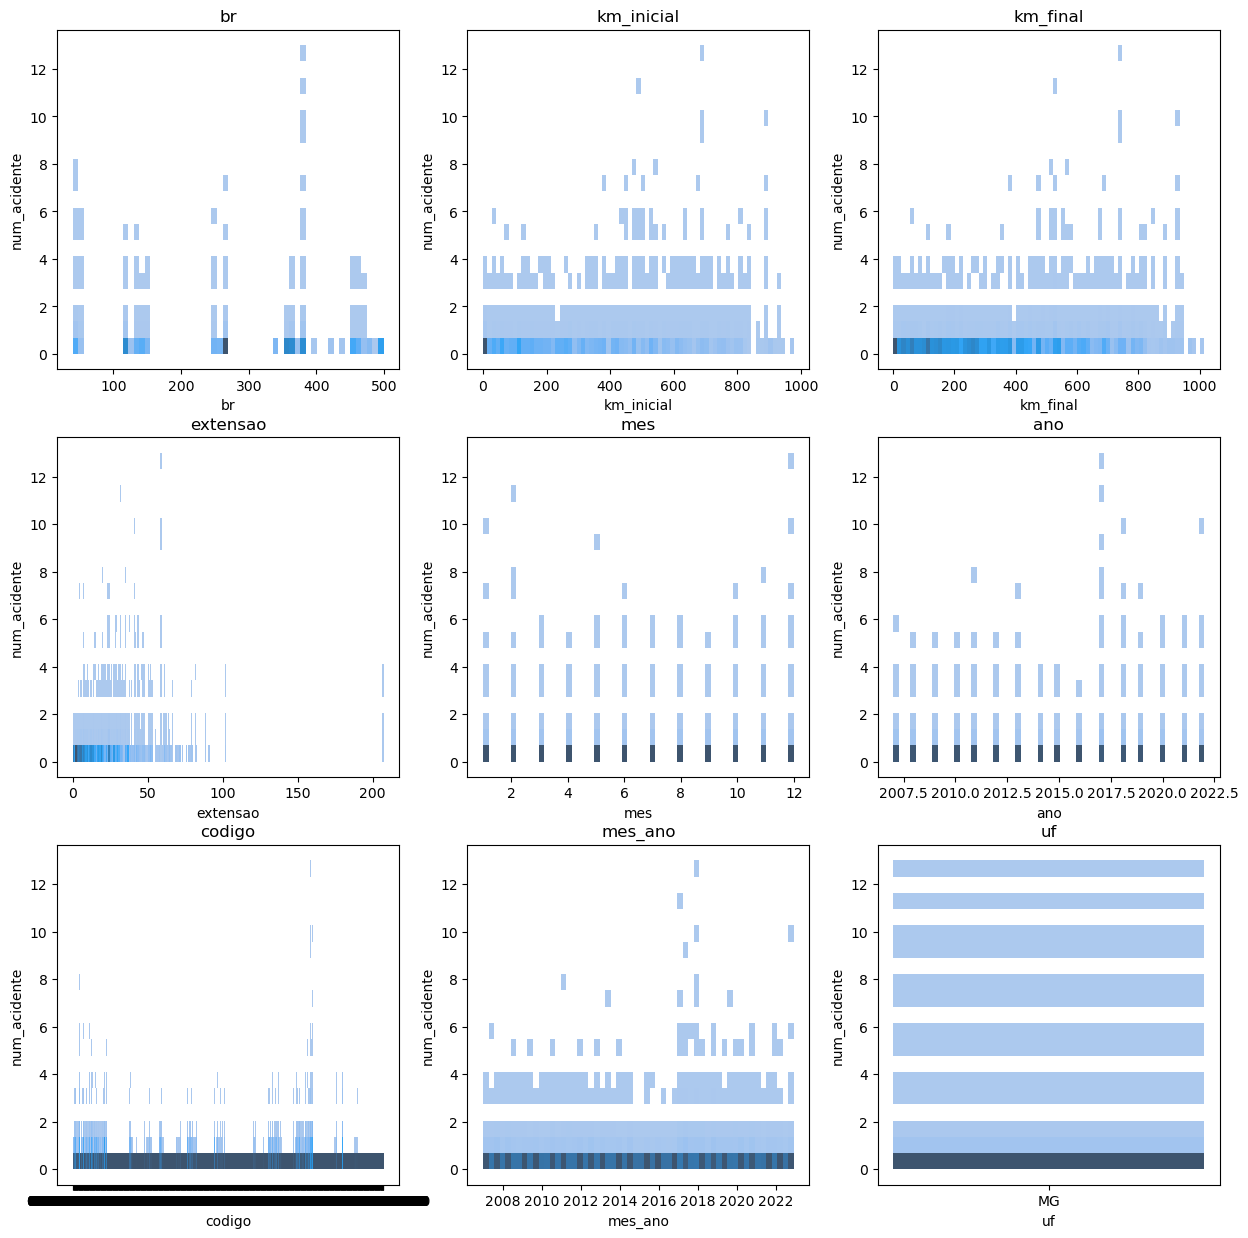

In [47]:
# Ajusta a distância entre as subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Cria uma figura com os subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Define as colunas para o pairplot
cols = ['br', 'km_inicial', 'km_final', 'extensao', 'mes', 'ano', 'codigo', 'mes_ano', 'uf']

# Loop pelos subplots e cria o pairplot para cada coluna
for i, ax in enumerate(axs.flatten()):
    if i < len(cols):
        sns.histplot(data=acidente_snv, x=cols[i], y='num_acidente', ax=ax)
        ax.set_title(cols[i])

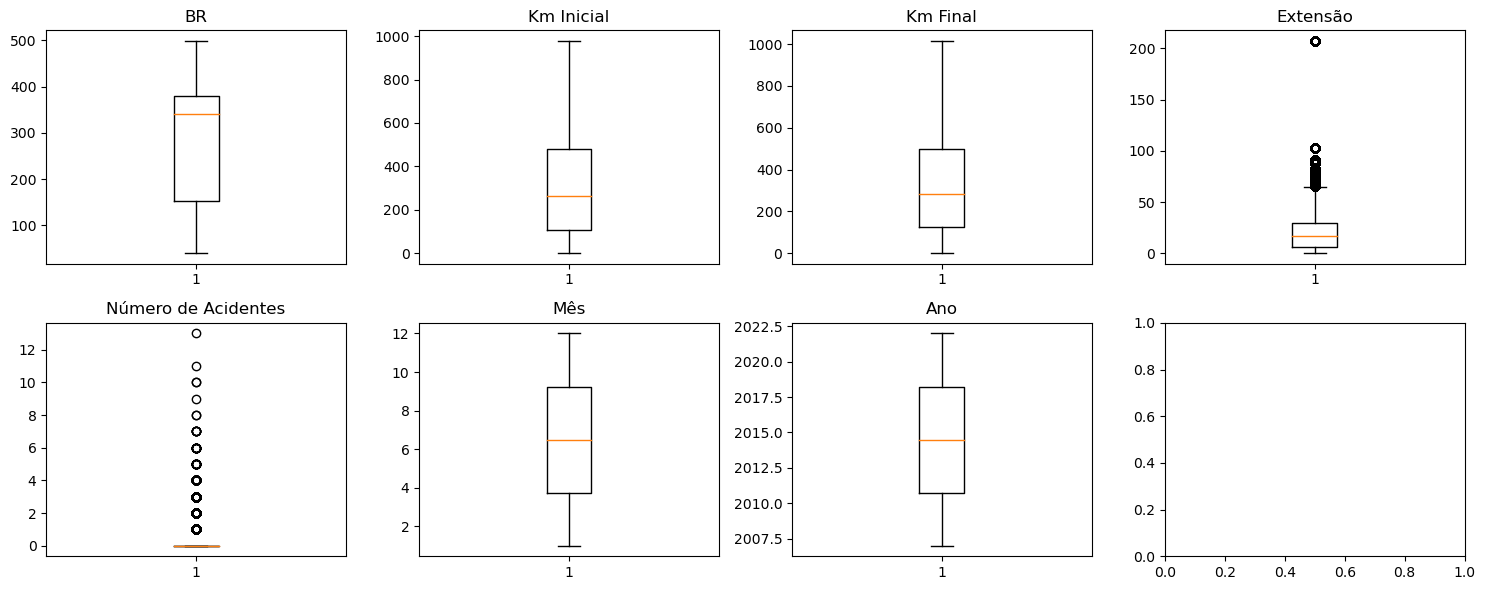

In [48]:
# Cria uma figura com 10 subplots, uma para cada variável
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))

# Cria um boxplot para cada variável
axs[0, 0].boxplot(acidente_snv['br'])
axs[0, 0].set_title('BR')

axs[0, 1].boxplot(acidente_snv['km_inicial'])
axs[0, 1].set_title('Km Inicial')

axs[0, 2].boxplot(acidente_snv['km_final'])
axs[0, 2].set_title('Km Final')

axs[0, 3].boxplot(acidente_snv['extensao'])
axs[0, 3].set_title('Extensão')

axs[1, 0].boxplot(acidente_snv['num_acidente'])
axs[1, 0].set_title('Número de Acidentes')

axs[1, 1].boxplot(acidente_snv['mes'])
axs[1, 1].set_title('Mês')

axs[1, 2].boxplot(acidente_snv['ano'])
axs[1, 2].set_title('Ano')

# Ajusta o espaçamento entre os subplots
plt.tight_layout()

# Exibe o gráfico
plt.show()

In [49]:
# Função de correlação.

def correlacoes(acidente_snv):

    corr = acidente_snv.corr().drop(acidente_snv.corr().index[0], axis='index').drop(acidente_snv.corr().index[-1], axis='columns')

    mascara = np.triu(np.ones(corr.shape)).astype(bool)

    for i in range(len(mascara)):
        for j in range(mascara.shape[1]):
            if i == j:
                mascara[i, j] = False

    sns.set(font_scale=1.0)
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 13))

    mapa_calor = sns.heatmap(corr, mask=mascara, annot=True, vmin=-1, vmax=1, cmap='coolwarm', linewidths=1)

    plt.show()


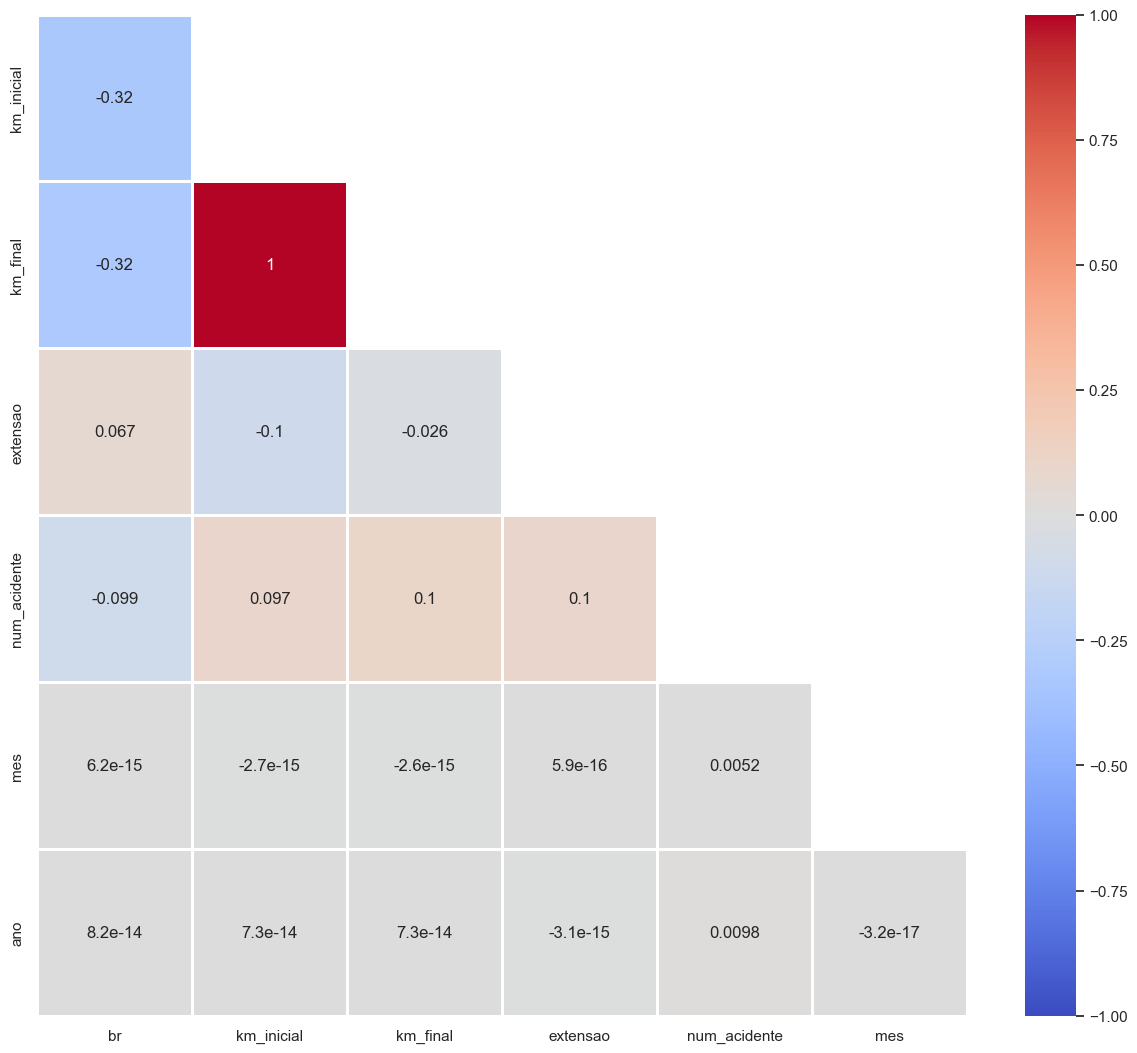

In [50]:
# Impressão das correlações
correlacoes(acidente_snv)

In [51]:
# Quantidade de acidentes 
acidente_snv.groupby('br')['num_acidente'].sum().sort_values(ascending=False).head(10)

br
381    2561.0
40     2100.0
116    1404.0
262    1152.0
365     957.0
50      525.0
267     365.0
251     303.0
153     233.0
135     217.0
Name: num_acidente, dtype: float64

In [52]:
# Seleciona os acidentes na BR 381 com o código desejado
acidente_381 = acidente_snv.loc[(acidente_snv['br'] == 381) & (acidente_snv['codigo'])]

# Realiza o merge com a tabela 'snv'
acidente_381 = pd.merge(acidente_381, snv[['codigo', 'Local de Início', 'Local de Fim']], on='codigo')

# Agrupa por 'br' e 'codigo', soma o número de acidentes e ordena de forma decrescente
acidente_381 = acidente_381.groupby(['br', 'codigo', 'Local de Início', 'Local de Fim'])['num_acidente'].sum().sort_values(ascending=False).head(10)

# Imprime o resultado
print(acidente_381)

br   codigo      Local de Início                                 Local de Fim                                       
381  381BMG0490  ENTR BR-262/381 (FIM CONTORNO BETIM)            ENTR MG-155                                            209.0
     381BMG0670  ENTR BR-265(B) (P/NEPOMUCENO)                   ENTR MG-167(A) (P/TRÊS CORAÇÕES)                       197.0
     381BMG0790  ENTR MG-295 (CAMBUÍ)                            ENTR MG-460 (P/TOLEDO)                                 174.0
     381BMG0770  ENTR BR-459 (P/POUSO ALEGRE)                    ENTR MG-295 (CAMBUÍ)                                   141.0
     381BMG0630  ENTR MG-332 (SANTO ANTÔNIO DO AMPARO)           ENTR BR-354 (PERDÕES)                                  100.0
     381BMG0530  ENTR MG-431 (P/ITAITIAIUÇU)                     ENTR MG-040 (ITAGUARA)                                 100.0
     381BMG0170  ACESSO À GOV. VALADARES                         ENTR R SÃO LUIZ (PERIQUITO)                             92.0
 

In [53]:
# Seleciona os acidentes na BR 040 com o código desejado
acidente_040 = acidente_snv.loc[(acidente_snv['br'] == 40) & (acidente_snv['codigo'])]

# Realiza o merge com a tabela 'snv'
acidente_040 = pd.merge(acidente_040, snv[['codigo', 'Local de Início', 'Local de Fim']], on='codigo')

# Agrupa por 'br' e 'codigo', soma o número de acidentes e ordena de forma decrescente
acidente_040 = acidente_040.groupby(['br', 'codigo', 'Local de Início', 'Local de Fim'])['num_acidente'].sum().sort_values(ascending=False).head(10)

# Imprime o resultado
print(acidente_040)

br  codigo      Local de Início                            Local de Fim                                                    
40  040BMG0360  ENTR MG-432 (P/ESMERALDAS)                 ENTR BR-135(B)/262(A)/381(A) (ANEL RODOVIÁRIO DE BELO HORIZONTE)    232.0
    040BMG0330  ENTR MG-238 (P/SETE LAGOAS)                ENTR MG-432 (P/ESMERALDAS)                                          204.0
    040BMG0270  ENTR MG-231                                ENTR MG-424 (P/SETE LAGOAS)                                         165.0
    040BMG0490  ENTR BR-383(B)/482 (CONSELHEIRO LAFAIETE)  ENTR MG-275 (P/CARANDAÍ)                                            112.0
    040BMG0510  ENTR MG-275 (P/CARANDAÍ)                   ACESSO ALTO DOCE (INÍCIO PISTA DUPLA)                               102.0
    040BMG0570  ENTR BR-499 (SANTOS DUMONT)                ENTR ANT UNIÃO E INDÚSTRIA (B. TRIUNFO)                              97.0
    040BMG0170  ENTR BR-365                                ENTR MG-220 (TRÊS M

In [54]:
# Seleciona os acidentes na BR 116 com o código desejado
acidente_116 = acidente_snv.loc[(acidente_snv['br'] == 116) & (acidente_snv['codigo'])]

# Realiza o merge com a tabela 'snv'
acidente_116 = pd.merge(acidente_116, snv[['codigo', 'Local de Início', 'Local de Fim']], on='codigo')

# Agrupa por 'br' e 'codigo', soma o número de acidentes e ordena de forma decrescente
acidente_116 = acidente_116.groupby(['br', 'codigo', 'Local de Início', 'Local de Fim'])['num_acidente'].sum().sort_values(ascending=False).head(10)

# Imprime o resultado
print(acidente_116)

br   codigo      Local de Início                            Local de Fim                          
116  116BMG1350  ENTR BR-482 (FERVEDOURO)                   ENTR BR-265(A)/356 (MURIAÉ)               114.0
     116BMG1450  ENTR BR-267(B) (P/TEBAS)                   ENTR BR-393(A)                             82.0
     116BMG1195  ACESSO ITANHOMI                            ACESSO P/FERNANDES TOURINHO E SOBRÁLIA     82.0
     116BMG1030  MEDINA (ACESSO SUL)                        ENTR BR-367 (P/ ITAOBIM)                   67.0
     116BMG1410  ENTR MG-454 (P/RECREIO)                    ENTR BR-120/267(A) (LEOPOLDINA)            66.0
     116BMG1230  ENTR BR-458(B) (P/IAPÚ)                    ENTR MG-425 (P/ENTRE FOLHAS)               63.0
     116BMG1130  ENTR BR-342(B)/418/MG-217 (TEÓFILO OTONI)  ACESSO ITAMBACURI                          62.0
     116BMG1050  ENTR BR-367 (P/ ITAOBIM)                   PADRE PARAÍSO (ACESSO SUL)                 59.0
     116BMG1370  ENTR BR-265(B)      

In [55]:
# Quantiodade de acidentes por mês
acidente_snv.groupby('mes')['num_acidente'].sum().sort_values(ascending=False).head(10)

mes
10    1006.0
2      947.0
11     944.0
12     930.0
3      870.0
1      854.0
7      837.0
8      835.0
5      816.0
6      814.0
Name: num_acidente, dtype: float64

In [56]:
# Quantiodade de acidentes por ano
acidente_snv.groupby('ano')['num_acidente'].sum().sort_values(ascending=False).head(10)

ano
2017    1414.0
2018     921.0
2020     799.0
2019     770.0
2007     715.0
2008     696.0
2012     642.0
2011     623.0
2010     599.0
2013     586.0
Name: num_acidente, dtype: float64

In [57]:
# Quantiodade de acidentes por mês/ano
acidente_snv.groupby('mes_ano')['num_acidente'].sum().sort_values(ascending=False).head(10)

mes_ano
2017-02-01    155.0
2017-11-01    148.0
2017-12-01    146.0
2017-03-01    133.0
2018-01-01    129.0
2018-02-01    129.0
2017-04-01    124.0
2017-05-01    120.0
2017-10-01    112.0
2017-06-01    110.0
Name: num_acidente, dtype: float64

## 5.0 - Criação, treinamento, aplicação e avaliação de Modelos de Machine Learning

## 5.1 - Etapas Iniciais

In [58]:
# Selecionando y e X
y = acidente_snv['num_acidente']
X = acidente_snv[['mes', 'ano', 'br', 'uf', 'km_inicial', 'km_final', 'extensao']]

In [59]:
# OneHotEncoder
# Codificar as colunas "UF" usando OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_enc = enc.fit_transform(X[['uf']])

# Obter as categorias codificadas
uf_categories = enc.categories_[0]

# Criar dataframes para as colunas codificadas
uf_encoded = pd.DataFrame(X_enc[:, :len(uf_categories)], index=X.index, columns=[f'uf_{category}' for category in uf_categories])

# Combinar as colunas codificadas com as outras variáveis independentes
X = pd.concat([X.drop(columns=['uf']), uf_encoded], axis=1)

In [60]:
# StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [61]:
# Model Selection - Splitter Functions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)

## 5.2 - Algoritmos

## 5.2.1 - KNN

In [62]:
# Grid Search
# Definir os valores dos hiperparâmetros a serem testados
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [1, 2],
    'metric' : ['cityblock', 'minkowski', 'euclidean']
    }

# Criar um objeto GridSearchCV com os valores dos hiperparâmetros a serem testados
grid = GridSearchCV(KNeighborsClassifier(), param_grid)

# Treinar o modelo com o conjunto de treinamento
grid.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid.best_params_)

Melhores hiperparâmetros: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


In [63]:
# Treinar o modelo
clf = KNeighborsClassifier(algorithm='ball_tree', metric='minkowski', n_neighbors=9, p=2, weights='uniform')
clf.fit(X_train, y_train)

# Fazer previsões com o conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o desempenho do modelo
print("Acurácia: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precisão: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted')*100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted')*100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted')*100))

Acurácia: 95.11%
Precisão: 91.90%
Recall: 95.11%
F1 Score: 93.07%


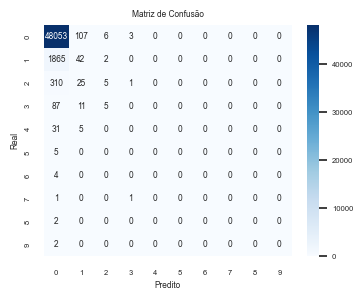

In [64]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar um gráfico de matriz de confusão
plt.figure(figsize=(4, 3))
sns.set(font_scale=0.5)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [65]:
# KFold + cross-validation score
resultados_knn_clf = []
for i in range (5):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    score = cross_val_score(clf, X, y, cv = kfold)
    resultados_knn_clf.append(score.mean())

df_resultados_knn_clf = pd.DataFrame(resultados_knn_clf,columns=['resultados_knn'])
df_resultados_knn_clf.describe()

,resultados_knn
count,5.000000
mean,0.950738
std,0.000090
min,0.950622
25%,0.950705
50%,0.950740
75%,0.950752
max,0.950871


## 5.2.2 - SGD Classifier

In [66]:
# Grid Search
# Definir os valores dos hiperparâmetros a serem testados
param_grid = {
    'loss' : ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty' : ['l2', 'l1', 'elasticnet', None],
    'alpha' : [0.0001, 0.001, 0.01, 0.1],
    'max_iter' : [5, 10, 20, 50, 100, 1000]
    }

# Criar um objeto GridSearchCV com os valores dos hiperparâmetros a serem testados
grid = GridSearchCV(SGDClassifier(random_state=42), param_grid)

# Treinar o modelo com o conjunto de treinamento
grid.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid.best_params_)

Melhores hiperparâmetros: {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 5, 'penalty': 'l2'}


In [67]:
# Treinar o modelo
clf = SGDClassifier(random_state=42, alpha=0.0001, loss='hinge', max_iter=5, penalty='l2')
clf.fit(X_train, y_train)

# Fazer previsões com o conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o desempenho do modelo
print("Acurácia: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precisão: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted')*100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted')*100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted')*100))

Acurácia: 95.25%
Precisão: 90.72%
Recall: 95.25%
F1 Score: 92.93%


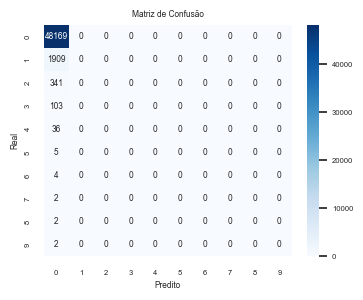

In [68]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar um gráfico de matriz de confusão
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [69]:
# KFold + cross-validation score
resultados_sgd_classifier_clf = []
for i in range (5):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    score = cross_val_score(clf, X, y, cv = kfold)
    resultados_sgd_classifier_clf.append(score.mean())

df_resultados_sgd_classifier = pd.DataFrame(resultados_sgd_classifier_clf,columns=['resultados_sgd_classifier'])
df_resultados_sgd_classifier.describe()

,resultados_sgd_classifier
count,5.000000e+00
mean,9.517725e-01
std,7.700000e-09
min,9.517725e-01
25%,9.517725e-01
50%,9.517725e-01
75%,9.517725e-01
max,9.517725e-01


## 5.2.3 - Random Forest Classifier

In [70]:
# Grid Search
# Definir os valores dos hiperparâmetros a serem testados
param_grid = {
    'n_estimators' : [25, 50, 75, 100],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'min_samples_split' : [2, 4, 6, 8, 10],
    'min_samples_leaf' : [1, 3, 5, 7]
    }

# Criar um objeto GridSearchCV com os valores dos hiperparâmetros a serem testados
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)

# Treinar o modelo com o conjunto de treinamento
grid.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid.best_params_)

Melhores hiperparâmetros: {'criterion': 'gini', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100}


In [71]:
# Treinar o modelo
clf = RandomForestClassifier(random_state=42, criterion='gini', min_samples_leaf=7, min_samples_split=2, n_estimators=100)
clf.fit(X_train, y_train)

# Fazer previsões com o conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o desempenho do modelo
print("Acurácia: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precisão: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted')*100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted')*100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted')*100))

Acurácia: 95.20%
Precisão: 92.14%
Recall: 95.20%
F1 Score: 93.12%


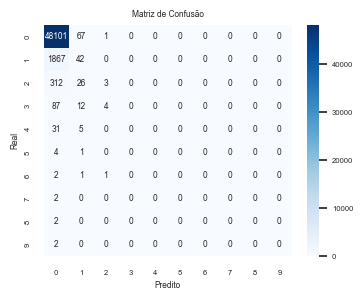

In [72]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar um gráfico de matriz de confusão
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [73]:
# KFold + cross-validation score
resultados_random_forest_classifier_clf = []
for i in range (5):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    score = cross_val_score(clf, X, y, cv = kfold)
    resultados_random_forest_classifier_clf.append(score.mean())

df_resultados_random_forest_classifier = pd.DataFrame(resultados_random_forest_classifier_clf,columns=['resultados_random_forest_classifier'])
df_resultados_random_forest_classifier.describe()

,resultados_random_forest_classifier
count,5.000000
mean,0.951337
std,0.000045
min,0.951280
25%,0.951304
50%,0.951345
75%,0.951363
max,0.951393


## 5.2.4 - Decision Tree Regressor

In [74]:
# Grid Search
# Definir os valores dos hiperparâmetros a serem testados
param_grid = {
    'criterion' : ['squared_error', 'friedman_mse', 'absolute_error'],
    }

# Criar um objeto GridSearchCV com os valores dos hiperparâmetros a serem testados
grid = GridSearchCV(DecisionTreeRegressor(random_state=42, ), param_grid)

# Treinar o modelo com o conjunto de treinamento
grid.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid.best_params_)

Melhores hiperparâmetros: {'criterion': 'squared_error'}


In [104]:
# Treinar o modelo
clf = DecisionTreeRegressor(random_state=42, criterion='squared_error')
clf.fit(X_train, y_train)

# Fazer previsões com o conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o desempenho do modelo
print("Acurácia: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precisão: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted')*100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted')*100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted')*100))

Acurácia: 92.03%
Precisão: 92.61%
Recall: 92.03%
F1 Score: 92.31%


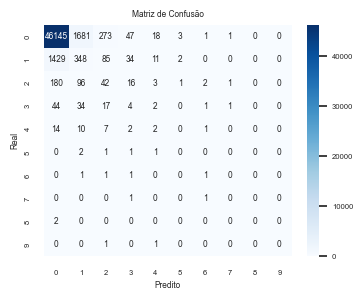

In [105]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar um gráfico de matriz de confusão
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [77]:
# KFold + cross-validation score
resultados_decision_tree_regressor_clf = []
for i in range (5):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    score = cross_val_score(clf, X, y, cv = kfold)
    resultados_decision_tree_regressor_clf.append(score.mean())

df_resultados_decision_tree_regressor = pd.DataFrame(resultados_decision_tree_regressor_clf,columns=['resultados_decision_tree_regressor'])
df_resultados_decision_tree_regressor.describe()

,resultados_decision_tree_regressor
count,5.000000
mean,-0.573700
std,0.017189
min,-0.591102
25%,-0.581496
50%,-0.576059
75%,-0.574638
max,-0.545207


## 5.2.5 - Regressão Logística

In [78]:
# Grid Search
# Definir os valores dos hiperparâmetros a serem testados
param_grid = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    }

# Criar um objeto GridSearchCV com os valores dos hiperparâmetros a serem testados
grid = GridSearchCV(LogisticRegression(random_state=42), param_grid)

# Treinar o modelo com o conjunto de treinamento
grid.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid.best_params_)

Melhores hiperparâmetros: {'solver': 'lbfgs'}


In [107]:
# Treinar o modelo
clf = LogisticRegression(random_state=42, solver='lbfgs')
clf.fit(X_train, y_train)

# Fazer previsões com o conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o desempenho do modelo
print("Acurácia: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precisão: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted')*100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted')*100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted')*100))

Acurácia: 95.25%
Precisão: 90.72%
Recall: 95.25%
F1 Score: 92.93%


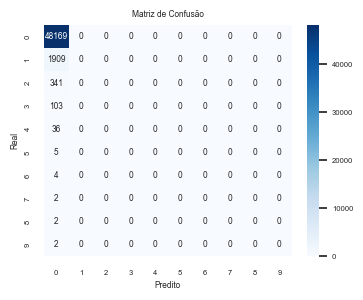

In [108]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar um gráfico de matriz de confusão
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [81]:
# KFold + cross-validation score
resultados_logistic_regression_clf = []
for i in range (5):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    score = cross_val_score(clf, X, y, cv = kfold)
    resultados_logistic_regression_clf.append(score.mean())

df_resultados_logistic_regression = pd.DataFrame(resultados_logistic_regression_clf,columns=['resultados_logistic_regression'])
df_resultados_logistic_regression.describe()

,resultados_logistic_regression
count,5.000000e+00
mean,9.517725e-01
std,7.700000e-09
min,9.517725e-01
25%,9.517725e-01
50%,9.517725e-01
75%,9.517725e-01
max,9.517725e-01


## 5.3 - Resultado

In [106]:
# Criar uma lista com os DataFrames a serem concatenados
dataframes = [df_resultados_knn_clf,
              df_resultados_sgd_classifier,
              df_resultados_logistic_regression,
              df_resultados_random_forest_classifier,
              df_resultados_decision_tree_regressor]

# Concatenar os DataFrames ao longo do eixo das colunas (axis=1)
resultados = pd.concat(dataframes, axis=1)

# Exibir o resultado
print(resultados.describe())

       resultados_knn  resultados_sgd_classifier  \
count        5.000000               5.000000e+00   
mean         0.950738               9.517725e-01   
std          0.000090               7.700000e-09   
min          0.950622               9.517725e-01   
25%          0.950705               9.517725e-01   
50%          0.950740               9.517725e-01   
75%          0.950752               9.517725e-01   
max          0.950871               9.517725e-01   

       resultados_logistic_regression  resultados_random_forest_classifier  \
count                    5.000000e+00                             5.000000   
mean                     9.517725e-01                             0.951337   
std                      7.700000e-09                             0.000045   
min                      9.517725e-01                             0.951280   
25%                      9.517725e-01                             0.951304   
50%                      9.517725e-01                          

## 5.4 - Aplicando as obras o melhor algoritmo

In [109]:
# Selecionando y_obra e X_obra
y_obra = acidente_obra['num_acidente']
X_obra = acidente_obra[['mes', 'ano', 'br', 'uf', 'km_inicial', 'km_final', 'extensao']]

In [110]:
# OneHotEncoder
# Codificar as colunas "UF" usando OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_obra_enc = enc.fit_transform(X_obra[['uf']])

# Obter as categorias codificadas
uf_categories = enc.categories_[0]

# Criar dataframes para as colunas codificadas
uf_encoded = pd.DataFrame(X_obra_enc[:, :len(uf_categories)], index=X_obra.index, columns=[f'uf_{category}' for category in uf_categories])

# Combinar as colunas codificadas com as outras variáveis independentes
X_obra = pd.concat([X_obra.drop(columns=['uf']), uf_encoded], axis=1)

In [111]:
# StandardScaler
scaler = StandardScaler()
X_obra = scaler.fit_transform(X_obra)

In [112]:
# Fazer previsões com o conjunto de teste
y_obra_pred = clf.predict(X_obra)

# Avaliar o desempenho do modelo
print("Acurácia: {:.2f}%".format(accuracy_score(y_obra, y_obra_pred)*100))
print("Precisão: {:.2f}%".format(precision_score(y_obra, y_obra_pred, average='weighted')*100))
print("Recall: {:.2f}%".format(recall_score(y_obra, y_obra_pred, average='weighted')*100))
print("F1 Score: {:.2f}%".format(f1_score(y_obra, y_obra_pred, average='weighted')*100))

Acurácia: 76.56%
Precisão: 58.61%
Recall: 76.56%
F1 Score: 66.40%


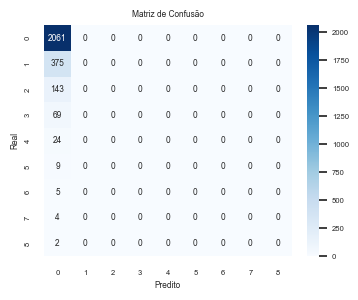

In [113]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_obra, y_obra_pred)

# Criar um gráfico de matriz de confusão
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [101]:
# Adicionar a coluna com as previsões na tabela
acidente_obra['num_acidente_pred'] = y_obra_pred

# Visualizar a tabela com as previsões
print(acidente_obra)

      obra    mes_ano  uf   br  km_inicial  km_final  extensao  num_acidente  \
0     G002 2015-07-01  MG  267        62.0      98.7      36.7           0.0   
1     G002 2015-08-01  MG  267        62.0      98.7      36.7           1.0   
2     G002 2015-09-01  MG  267        62.0      98.7      36.7           0.0   
3     G002 2015-10-01  MG  267        62.0      98.7      36.7           0.0   
4     G002 2015-11-01  MG  267        62.0      98.7      36.7           0.0   
...    ...        ...  ..  ...         ...       ...       ...           ...   
2687  Z205 2021-03-01  MG  381       149.0     264.7     115.7           0.0   
2688  Z207 2020-11-01  MG  364       187.5     278.2      90.7           0.0   
2689  Z207 2020-12-01  MG  364       187.5     278.2      90.7           0.0   
2690  Z208 2020-11-01  MG  116       374.1     469.8      95.7           0.0   
2691  Z208 2020-12-01  MG  116       374.1     469.8      95.7           1.0   

      mes   ano  num_acidente_pred  
0 

In [102]:
# Salvar o resultado em um novo arquivo CSV
acidente_obra.to_csv('acidente_obra.csv', index=False, sep=';', decimal=',', encoding = 'cp1252')

In [103]:
acidente_obra.describe()

,br,km_inicial,km_final,extensao,num_acidente,mes,ano,num_acidente_pred
count,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.0
mean,286.961738,250.970468,323.086397,72.115929,0.402303,6.471397,2015.285661,0.0
std,138.512331,244.883630,251.268563,26.406480,0.913442,3.470682,3.408807,0.0
min,40.000000,0.000000,4.900000,4.900000,0.000000,1.000000,2007.000000,0.0
25%,146.000000,62.000000,118.600000,52.000000,0.000000,3.000000,2013.000000,0.0
50%,364.000000,152.900000,235.700000,73.600000,0.000000,6.000000,2016.000000,0.0
75%,369.000000,374.100000,471.300000,90.400000,0.000000,9.250000,2018.000000,0.0
max,494.000000,857.200000,949.800000,118.900000,8.000000,12.000000,2021.000000,0.0
